In [1]:
import os
import subprocess
import bt
import datetime as dt

tickers = subprocess.run(args=["python", os.getcwd() + "\\data_cleaning.py"],text=True,stdout=subprocess.PIPE)

results = tickers.stdout.strip('""[]\n').split(', ')

symbols = [element.strip("'\"") for element in results]

current_date = dt.date.today()
start_date = current_date - dt.timedelta(days=365)

num_previous_trading_days = sum(1 for day in range((current_date - start_date).days + 1) if (start_date + dt.timedelta(days=day)).weekday() < 5)

days = round((1.9*num_previous_trading_days)-1,0)

start = (current_date - dt.timedelta(days=days)).strftime("%Y-%m-%d")

df = bt.get(symbols,start=start)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


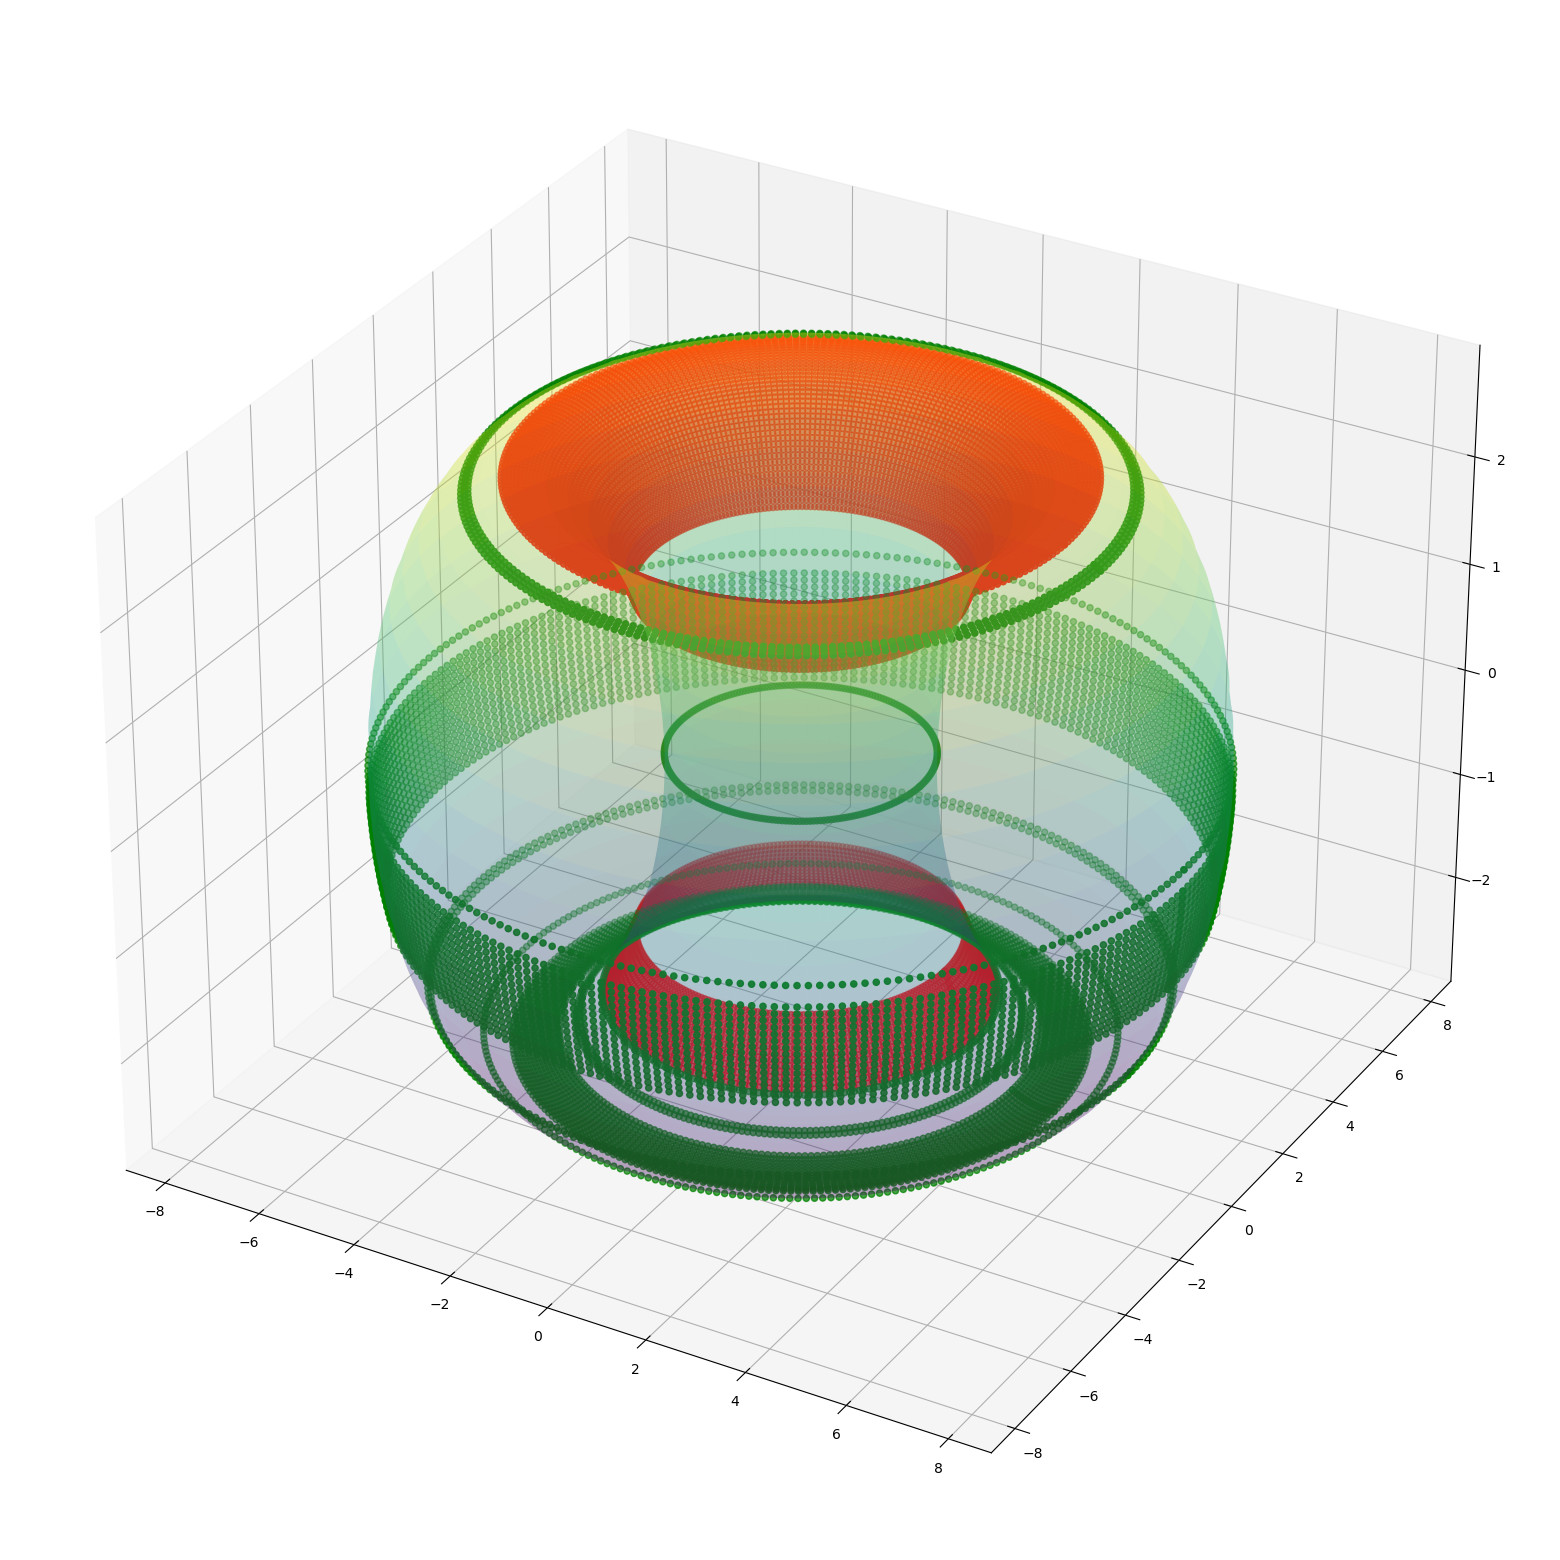

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate some random price data
big = 2*np.pi

norm_price = ((df-df.min())/(df.max()-df.min())) * big

# Calculate the mean and standard deviation
window = 50
rolling_mean = norm_price.rolling(window=window).mean()
rolling_mean = rolling_mean.loc[rolling_mean.index >= start_date.strftime("%Y-%m-%d")]

rolling_std = norm_price.rolling(window=window).std()
rolling_std = rolling_std.loc[rolling_std.index >= start_date.strftime("%Y-%m-%d")]

df = df.loc[df.index >= start_date.strftime("%Y-%m-%d")]
df = df-df.iloc[0,:]

# Create signals
buy_signal = df < rolling_mean - (2 * rolling_std)
sell_signal = df > rolling_mean + (2 * rolling_std)

# Define parametric equations for a torus
def torus_parametric(u, v, R, r):
    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)
    return x, y, z

# Parameters for the torus
R = (rolling_mean["cort"] + (2 * rolling_std["cort"])).mean()  # Major radius
r = rolling_mean["cort"].mean()  # Minor radius

# Generate torus coordinates
u = np.linspace(0,big,len(df))
v = np.linspace(0,big,len(df))
U, V = np.meshgrid(u, v)
X, Y, Z = torus_parametric(U, V, R, r)

# Plot the torus
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.2, cmap='viridis')

# Plot the price data
ax.scatter(X[buy_signal["cort"]], Y[buy_signal["cort"]], Z[buy_signal["cort"]], color='g', label='Buy Signal')
ax.scatter(X[sell_signal["cort"]], Y[sell_signal["cort"]], Z[sell_signal["cort"]], color='r', label='Sell Signal')

plt.show()

In [ ]:
buy_signal["BuySignal"] = "Buy"
sell_signal["SellSignal"] = "Sell"

buy_signal = buy_signal.rename(columns={0:"BuyAction"})
sell_signal = sell_signal.rename(columns={0:"SellAction"})

actions = pd.concat([buy_signal,sell_signal],axis=1)
                     
actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

actions = pd.concat([buy,sell,hold],axis=0).reset_index()

actions.columns = ["Date", "Signal"]

actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

actions["Date"] = list(tick.index)

actions

In [ ]:
buy_signal["BuySignal"] = "Buy"


sell_signal["SellSignal"] = "Sell"

pd.concat([buy_signal,sell_signal],axis=1)